In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

In [23]:
pd.set_option('display.max_colwidth', None)

In [53]:
model_data = pd.read_csv('../datasets/reddit_data_model_ready.csv')
original_reddit_df = pd.read_csv('../datasets/subreddit_data_2023-10-20.csv')

In [25]:
model_data.fillna('NA', inplace = True)

In [26]:
model_data.isnull().sum()

Unnamed: 0               0
id                       0
type                     0
title                    0
self_text                0
subreddit                0
upvote_ratio             0
link_address             0
user                     0
datetime                 0
title_length_chars       0
title_length_words       0
title_avg_word_length    0
url_content              0
url_domain               0
external_link            0
dtype: int64

In [27]:
transformers = [
    ('title_vectorizer', CountVectorizer(binary= True, max_df = 0.9, min_df= 1, ngram_range=(1,1), stop_words=None), 'title'),
    ('url_content_vectorizer', CountVectorizer(binary = False, max_df=0.9, min_df=2, ngram_range=(2,2), stop_words='english'), 'url_content'),
    ('domain_one_hot', OneHotEncoder(drop='first', handle_unknown = 'ignore'), ['url_domain'])
]

In [28]:
pipe_nb = Pipeline([
    ('cvecs', ColumnTransformer(transformers, remainder = 'passthrough')),
    ('nb', MultinomialNB())
])

In [29]:
X = model_data.loc[: , ['title', 'url_content', 'url_domain']]
y = model_data['subreddit']

In [30]:
pipe_nb.fit(X, y)

Pipeline(steps=[('cvecs',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('title_vectorizer',
                                                  CountVectorizer(binary=True,
                                                                  max_df=0.9),
                                                  'title'),
                                                 ('url_content_vectorizer',
                                                  CountVectorizer(max_df=0.9,
                                                                  min_df=2,
                                                                  ngram_range=(2,
                                                                               2),
                                                                  stop_words='english'),
                                                  'url_content'),
                                                 ('domain_one_hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['url_domain'])])),
                ('nb', MultinomialNB())])

In [31]:
pipe_nb.score(X, y)

0.9805798687089715

In [32]:
y_preds = pipe_nb.predict(X)

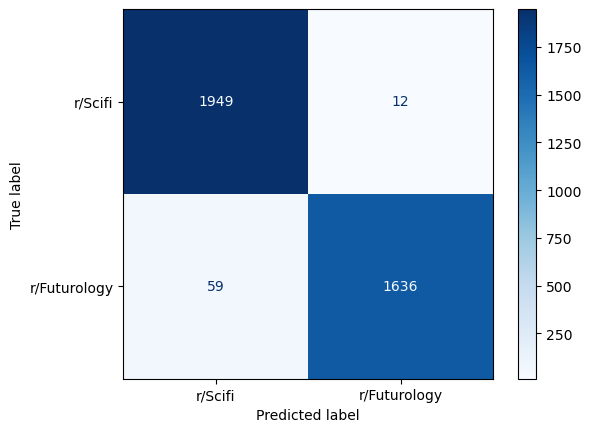

In [33]:
ConfusionMatrixDisplay.from_estimator(pipe_nb, X, y, cmap = 'Blues', display_labels=['r/Scifi', 'r/Futurology'])

In [34]:
recall_score(y, y_preds)

0.9651917404129794

In [35]:
results = pd.DataFrame({
    'actually Futurology' : y,
    'predicted Futurology' : y_preds
})

false_positives = results[(results['actually Futurology'] == 0) & (results['predicted Futurology'] == 1)].index

false_positives

Int64Index([1766, 2227, 2322, 2416, 2422, 2558, 2664, 2818, 3124, 3174, 3355,
            3530],
           dtype='int64')

In [36]:
false_negatives = results[(results['actually Futurology'] == 1) & (results['predicted Futurology'] == 0)].index

false_negatives

Int64Index([  36,   41,   42,   50,   81,  102,  120,  144,  148,  156,  160,
             169,  193,  215,  243,  253,  268,  271,  277,  286,  296,  302,
             321,  324,  329,  330,  364,  372,  381,  403,  428,  435,  439,
             455,  457,  471,  491,  501,  514,  520,  526,  528,  542,  555,
             556,  564,  575,  588,  597,  608,  611,  615,  641,  696,  897,
            1052, 1200, 1518, 1605],
           dtype='int64')

In [37]:
post_prediction_df = model_data.copy()

In [38]:
post_prediction_df['pred_futurology'] = y_preds

In [39]:
post_prediction_df.shape

(3656, 17)

In [40]:
post_prediction_df['space'] = ' '

In [41]:
post_prediction_df['title_and_url_content'] = post_prediction_df['title'] + post_prediction_df['space'] + post_prediction_df['url_content']

In [42]:
post_prediction_df_X = post_prediction_df.loc[ post_prediction_df['pred_futurology'] == 1 , ['title_and_url_content']]

In [43]:
X = post_prediction_df_X['title_and_url_content']
X.shape

(1648,)

In [44]:
cvec = CountVectorizer(stop_words='english', ngram_range=(2,4))

In [45]:
X_cvec = cvec.fit_transform(X)

In [46]:
X_df = pd.DataFrame(X_cvec.todense(), columns= cvec.get_feature_names_out())

Text(0.5, 1.0, 'Most Common Futurology Title Terms (NGrams (2,4))')

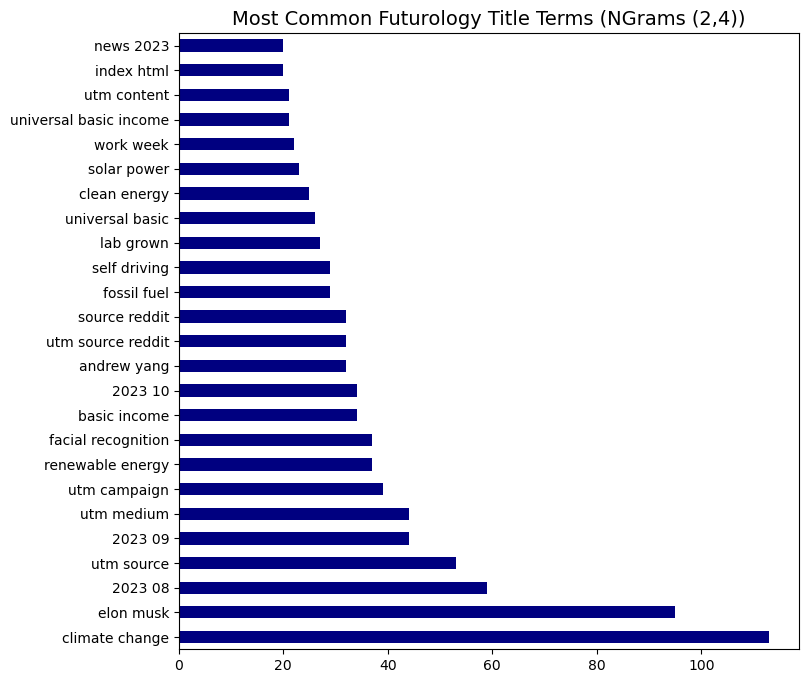

In [47]:
plt.figure(figsize=(8, 8))
X_df.sum().sort_values(ascending=False).head(25).plot.barh( color = 'navy')
plt.title('Most Common Futurology Title Terms (NGrams (2,4))', size=14)
#plt.savefig('../images/common_ngrams.png')

In [48]:
post_prediction_df_urls = post_prediction_df.loc[ post_prediction_df['pred_futurology'] == 1 , ['url_domain']]

Text(0.5, 1.0, 'Most Common Externally Linked To Sources')

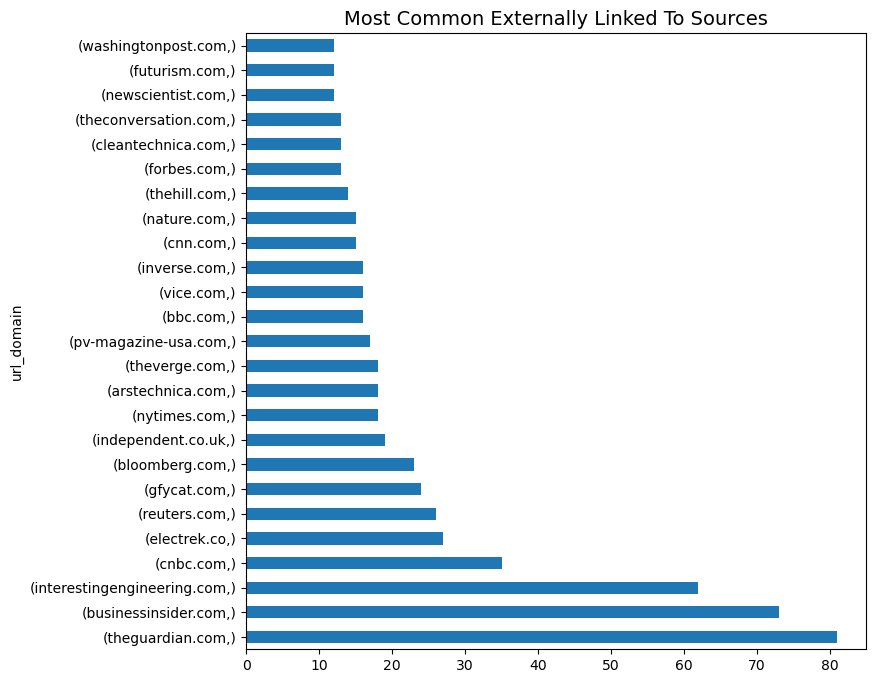

In [49]:
plt.figure(figsize=(8, 8))
post_prediction_df_urls.value_counts()[1:26].plot.barh()
plt.title('Most Common Externally Linked To Sources', size=14)
#plt.savefig('../images/common_domains.png')

In [50]:
results = pd.DataFrame({
    'actually Futurology' : y,
    'predicted Futurology' : y_preds
})

false_positives = results[(results['actually Futurology'] == 0) & (results['predicted Futurology'] == 1)].index

false_positives

Int64Index([1766, 2227, 2322, 2416, 2422, 2558, 2664, 2818, 3124, 3174, 3355,
            3530],
           dtype='int64')

In [51]:
false_negatives = results[(results['actually Futurology'] == 1) & (results['predicted Futurology'] == 0)].index

false_negatives

Int64Index([  36,   41,   42,   50,   81,  102,  120,  144,  148,  156,  160,
             169,  193,  215,  243,  253,  268,  271,  277,  286,  296,  302,
             321,  324,  329,  330,  364,  372,  381,  403,  428,  435,  439,
             455,  457,  471,  491,  501,  514,  520,  526,  528,  542,  555,
             556,  564,  575,  588,  597,  608,  611,  615,  641,  696,  897,
            1052, 1200, 1518, 1605],
           dtype='int64')

In [56]:
original_reddit_df.iloc[[1766, 2227, 2322, 2416, 2422, 2558, 2664, 2818, 3124, 3174, 3355,
            3530], [2, 4]]

,title,subreddit
1766,Ice 9,scifi
2227,What technologies could potentially be invented in the near future?,scifi
2322,"Due to the universe's expansion, 94% of the galaxies in the observable universe are now beyond reach even at light speed. Hypothetically, if we intercepted a radio signal travelling for hundreds of millions of years from a civilization in one of those galaxies, we'd never be able to respond.",scifi
2416,"Would you opt to forgo a natural birth and use a detachable, artificial womb if the technology became available in the future?",scifi
2422,How to cause a global dark age?,scifi
2558,"According to Nikola Tesla, Pyramids in the Egypt were giant transmitters of energy. What's your opinion? Is it true?",scifi
2664,Join the Battle for Net Neutrality! Don't let the FCC destroy the internet!,scifi
2818,"An Engineer at a mining outpost on the far side of Moon is at the end of his 3-year contract with Lunar Industries. With no Live comms, he spends time sending recorded messages to his family. One day, he spies on his AI computer GERTY making a live call to Earth, and things start to unravel!",scifi
3124,Awful news: Iain M Banks has late-stage cancer and less than a year to live,scifi
3174,San Francisco becomes the first US city to ban facial recognition by government agencies,scifi


In [57]:
original_reddit_df.iloc[[  36,   41,   42,   50,   81,  102,  120,  144,  148,  156,  160,
             169,  193,  215,  243,  253,  268,  271,  277,  286,  296,  302,
             321,  324,  329,  330,  364,  372,  381,  403,  428,  435,  439,
             455,  457,  471,  491,  501,  514,  520,  526,  528,  542,  555,
             556,  564,  575,  588,  597,  608,  611,  615,  641,  696,  897,
            1052, 1200, 1518, 1605], [2, 4]]

,title,subreddit
36,Will we ever send something out of our universe?,Futurology
41,Genuine question,Futurology
42,Remembering Jacque Fresco,Futurology
50,What recent/contemporary futurists should I be reading?,Futurology
81,How should I feel about the future?,Futurology
102,Best prediction from an underestimated source?,Futurology
120,Should I be optimistic about the future?,Futurology
144,What will the future of space travel be like and humanity?,Futurology
148,What are your thoughts on the possibility of a base on the surface of Mars?,Futurology
156,"10 years ago, YouTube served as a platform for a Transhumanist series called H+. Today it stands as one of the more prescient pieces of the 2000's on the risks and dangers of this post-modern digital Pandora's Box",Futurology
